# **Brain MRI image generation using DCGAN**
---


# 🔧 **Setup and Imports** 

Let's begin by setting up the necessary libraries and importing the dataset.  

### 📦 **Installing Required Libraries**

In [1]:
from __future__ import print_function
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from PIL import Image
from tqdm import tqdm

manualSeed = 999
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [3]:
dataroot = "/kaggle/input/brain-mri-images-for-brain-tumor-detection" 

workers = 2
batch_size = 64
image_size = 64
nc = 3
nz = 100
ngf = 64
ndf = 64
num_epochs = 500
lr = 0.0002
beta1 = 0.5
ngpu = 1

# 3. Dataset and DataLoader 🗂️


dataloader:  <enumerate object at 0x7c89a3c7bec0>


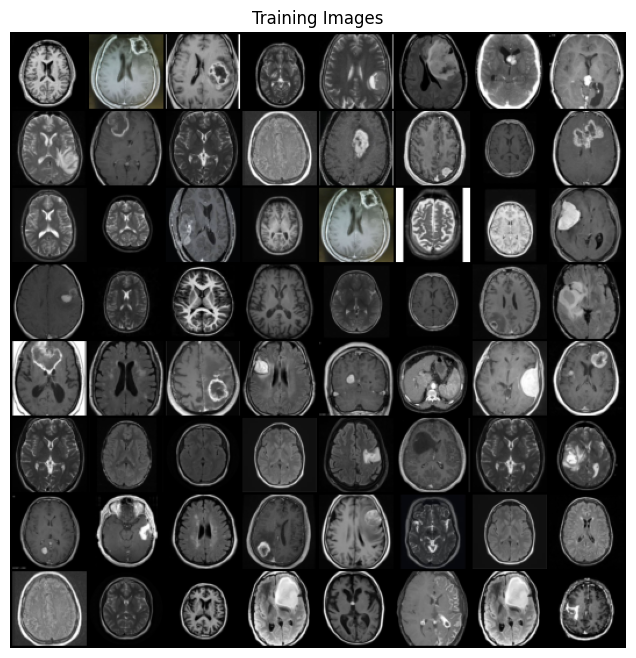

In [4]:

dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)
print("dataloader: ", enumerate(dataloader))

device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [6]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# 4. Neural Networks Architecture 

 DCGAN model.

---

## 4.1 Generator 🎨



In [7]:

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
       
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
     
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
    
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
          
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
           
        )

    def forward(self, input):
        return self.main(input)


In [8]:

netG = Generator(ngpu).to(device)
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))
netG.apply(weights_init)

print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


## 4.2 Discriminator 


In [9]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
       
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
    
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
      
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
       
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [10]:

netD = Discriminator(ngpu).to(device)
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))
netD.apply(weights_init)

print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [11]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

## 5. Training Loop 


In [12]:
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        netD.zero_grad()
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        output = netD(real_cpu).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(fake_label)
        output = netD(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        netG.zero_grad()
        label.fill_(real_label)
        output = netD(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        iters += 1
        
        if iters % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        if (epoch == 300):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

            output_path = '/kaggle/working/DCGAN_results_epoch_300/'
            if not os.path.exists(output_path):
                os.makedirs(output_path)
            
            for i in range(64):
                vutils.save_image(fake[i], '%s/fake_samples_epoch_300_%d.png' %
                                  (output_path, i), normalize=True)


Starting Training Loop...
[6/500][1/8]	Loss_D: 0.2326	Loss_G: 24.3968	D(x): 0.8347	D(G(z)): 0.0000 / 0.0000
[12/500][3/8]	Loss_D: 0.2291	Loss_G: 5.7074	D(x): 0.9208	D(G(z)): 0.1186 / 0.0049
[18/500][5/8]	Loss_D: 0.7174	Loss_G: 13.3718	D(x): 0.5595	D(G(z)): 0.0000 / 0.0000
[24/500][7/8]	Loss_D: 0.0643	Loss_G: 6.8506	D(x): 0.9426	D(G(z)): 0.0022 / 0.0024
[31/500][1/8]	Loss_D: 0.4842	Loss_G: 10.7075	D(x): 0.9237	D(G(z)): 0.2093 / 0.0001
[37/500][3/8]	Loss_D: 0.4975	Loss_G: 12.3906	D(x): 0.9979	D(G(z)): 0.3096 / 0.0000
[43/500][5/8]	Loss_D: 0.1996	Loss_G: 9.7770	D(x): 0.8565	D(G(z)): 0.0002 / 0.0004
[49/500][7/8]	Loss_D: 0.7532	Loss_G: 7.4456	D(x): 0.6088	D(G(z)): 0.0001 / 0.0024
[56/500][1/8]	Loss_D: 0.0978	Loss_G: 6.2719	D(x): 0.9574	D(G(z)): 0.0456 / 0.0046
[62/500][3/8]	Loss_D: 0.0850	Loss_G: 6.3818	D(x): 0.9488	D(G(z)): 0.0041 / 0.0057
[68/500][5/8]	Loss_D: 0.0522	Loss_G: 7.1072	D(x): 0.9830	D(G(z)): 0.0310 / 0.0021
[74/500][7/8]	Loss_D: 0.1383	Loss_G: 5.4116	D(x): 0.9161	D(G(z)): 0.0

## 6. Results and Visualization 



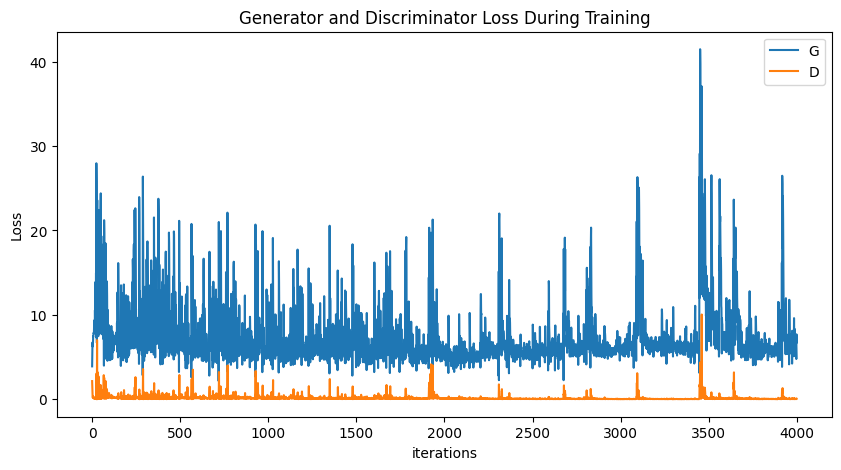

In [13]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

##  Visualizing the Generated Images


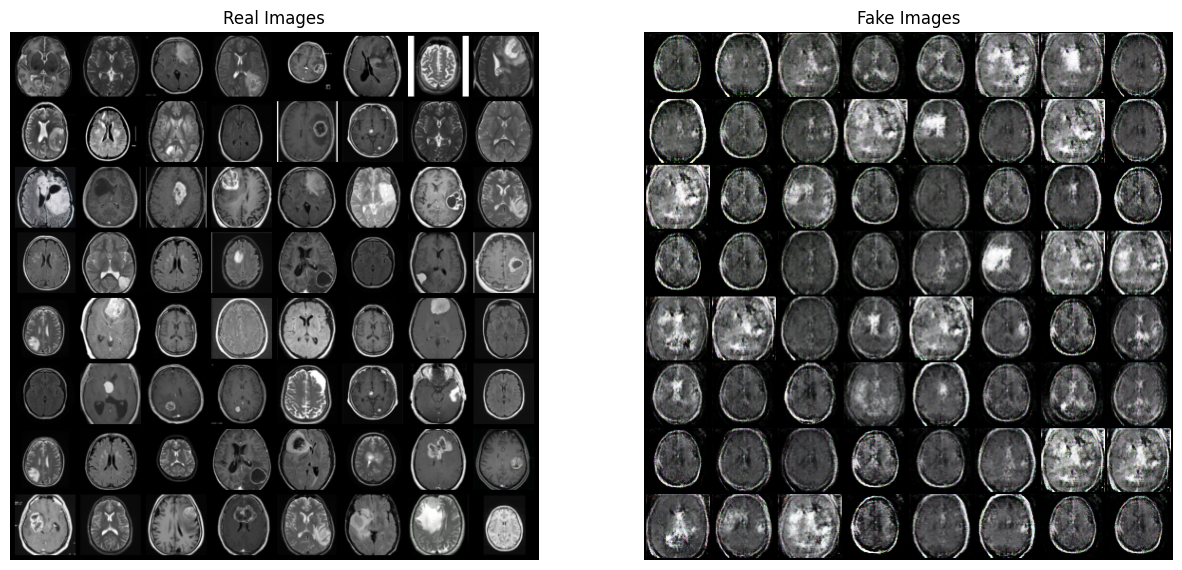

In [14]:
real_batch = next(iter(dataloader))
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))


plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show() 

****Create A Neural Network and Train it on the training dataset**# 

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import os
from PIL import Image
import numpy as np

# Set environment variable to enable synchronous CUDA error reporting for debugging
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

# Custom dataset class (assuming images are in 'yes' and 'no' directories)
class BrainTumorDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []
        self.class_mapping = {'no': 0, 'yes': 1}

        # Loop through the root directory and get images and labels
        for label in ['no', 'yes']:
            label_dir = os.path.join(root_dir, label)
            for img_name in os.listdir(label_dir):
                if img_name.endswith('.jpg') or img_name.endswith('.png'):
                    img_path = os.path.join(label_dir, img_name)
                    self.images.append(img_path)
                    self.labels.append(self.class_mapping[label])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]
        img = Image.open(img_path)
        img = img.convert('RGB')  # Ensure image is in RGB format

        if self.transform:
            img = self.transform(img)

        return img, label

# Hyperparameters
batch_size = 32
image_size = 64
num_classes = 2  # Binary classification: 'yes' and 'no'
lr = 0.0002
num_epochs = 500
ngpu = 1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data preprocessing and augmentation
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Dataset and DataLoader
dataroot = "/kaggle/input/brain-mri-images-for-brain-tumor-detection"
dataset = BrainTumorDataset(root_dir=dataroot, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

# Model definition
class TumorClassifier(nn.Module):
    def __init__(self, num_classes):
        super(TumorClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(128 * (image_size // 4) * (image_size // 4), 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 128 * (image_size // 4) * (image_size // 4))
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Instantiate the model and move it to the device (GPU or CPU)
model = TumorClassifier(num_classes=num_classes).to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, betas=(0.5, 0.999))

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = correct / total

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

    # Optionally, save the model checkpoint every few epochs
    if (epoch + 1) % 100 == 0:
        torch.save(model.state_dict(), f"model_epoch_{epoch+1}.pth")

# End of training
print("Training Finished!")


Epoch [1/500], Loss: 0.8646, Accuracy: 0.4798
Epoch [2/500], Loss: 0.6076, Accuracy: 0.6705
Epoch [3/500], Loss: 0.5278, Accuracy: 0.7803
Epoch [4/500], Loss: 0.4338, Accuracy: 0.7803
Epoch [5/500], Loss: 0.4514, Accuracy: 0.7746
Epoch [6/500], Loss: 0.3554, Accuracy: 0.8150
Epoch [7/500], Loss: 0.3033, Accuracy: 0.8902
Epoch [8/500], Loss: 0.2868, Accuracy: 0.8960
Epoch [9/500], Loss: 0.2825, Accuracy: 0.8671
Epoch [10/500], Loss: 0.2094, Accuracy: 0.9422
Epoch [11/500], Loss: 0.1827, Accuracy: 0.9480
Epoch [12/500], Loss: 0.1942, Accuracy: 0.9364
Epoch [13/500], Loss: 0.1298, Accuracy: 0.9769
Epoch [14/500], Loss: 0.1241, Accuracy: 0.9711
Epoch [15/500], Loss: 0.1003, Accuracy: 0.9653
Epoch [16/500], Loss: 0.0989, Accuracy: 0.9653
Epoch [17/500], Loss: 0.1264, Accuracy: 0.9653
Epoch [18/500], Loss: 0.0746, Accuracy: 0.9827
Epoch [19/500], Loss: 0.0543, Accuracy: 0.9884
Epoch [20/500], Loss: 0.0606, Accuracy: 0.9827
Epoch [21/500], Loss: 0.0770, Accuracy: 0.9884
Epoch [22/500], Loss: 

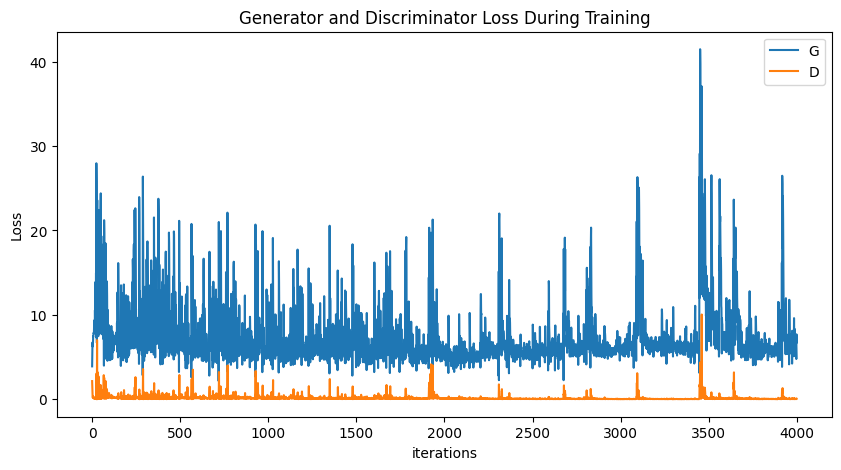

In [22]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

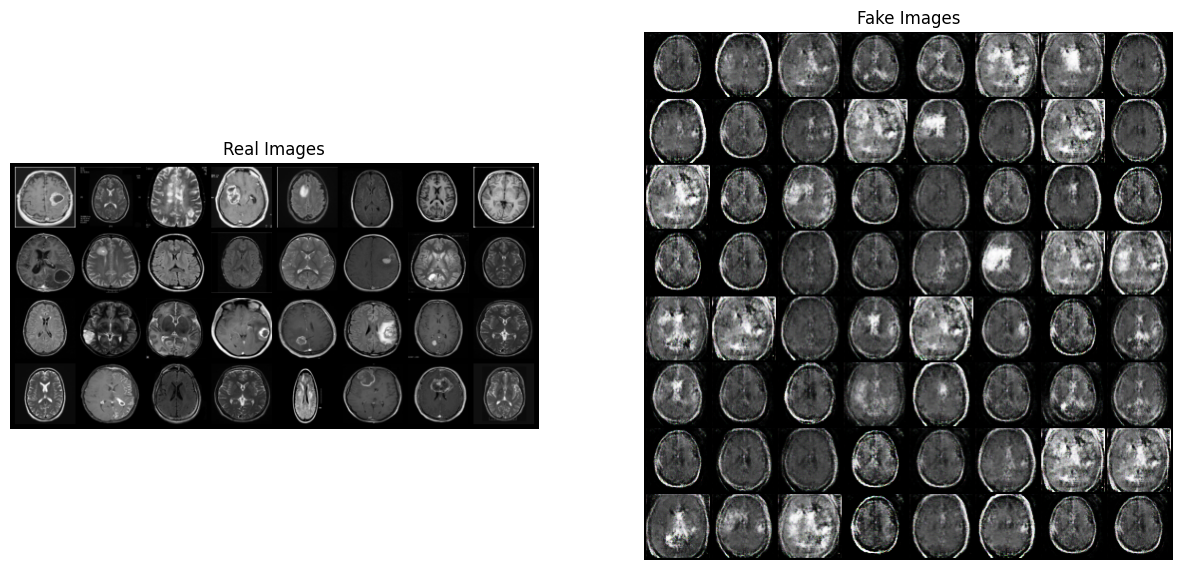

In [23]:
real_batch = next(iter(dataloader))
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))


plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()